In [ ]:
# Based on the academic paper Bengio et al. 2003

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Read in all the words from data
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [43]:
len(words)

32033

In [44]:
# build out the vocabulary of characters and mappings again

chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [46]:
# building the dataset

block_size = 4
X, Y = [], []
for w in words[:4]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

.... ---> e
...e ---> m
..em ---> m
.emm ---> a
emma ---> .
.... ---> o
...o ---> l
..ol ---> i
.oli ---> v
oliv ---> i
livi ---> a
ivia ---> .
.... ---> a
...a ---> v
..av ---> a
.ava ---> .
.... ---> i
...i ---> s
..is ---> a
.isa ---> b
isab ---> e
sabe ---> l
abel ---> l
bell ---> a
ella ---> .


In [47]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([25, 4]), torch.int64, torch.Size([25]), torch.int64)

In [48]:
def build_dataset(words):
    block_size = 4
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [58]:
C = torch.randn((27,10))
C[5]

tensor([ 1.0344,  0.9567, -1.1993,  0.1830,  2.1154,  2.2736,  0.0542, -1.0533,
         0.4505, -0.6161])

In [72]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 4, 10])

In [73]:
W1 = torch.rand((20, 100))
b1 = torch.randn(100)

There is significant nuance to this emb.view() step. You can see that emb is of size [32, 3, 2] above, which will not work for hte matrix multiplication with W1. W1 has six rows because there are 6 total features being used as context for the output. But in emb we have those features stored as matrices with 3 rows and 2 columns. tensor.view() allows us to automatically reshape the tensor to the correct size while retaining all the information. Note view() is a subset of reshape(), reshape() will generate a view() if shapes are compatible or a copy if the shapes are incompatible. 

In [74]:
h = torch.tanh(emb.view(-1, 20) @ W1 + b1) 
h

tensor([[-0.9981, -0.9808,  0.4399,  ..., -0.6002, -0.9881, -0.9937],
        [-0.9981, -0.9808,  0.4399,  ..., -0.6002, -0.9881, -0.9937],
        [-0.9981, -0.9808,  0.4399,  ..., -0.6002, -0.9881, -0.9937],
        ...,
        [ 0.9724, -0.9672, -0.5958,  ...,  0.9607,  0.8425,  0.9598],
        [ 0.6323,  0.4963,  0.8241,  ...,  0.9945,  0.9228,  0.9993],
        [-0.8974, -0.7638, -0.7376,  ...,  0.3686,  0.9638, -0.8973]])

In [75]:
h.shape

torch.Size([365250, 100])

In [76]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [77]:
logits = h @ W2 + b2

In [78]:
logits.shape

torch.Size([365250, 27])

In [79]:
counts = logits.exp()

In [80]:
prob = counts / counts.sum(1, keepdims=True)

In [81]:
prob.shape

torch.Size([365250, 27])

In [82]:
-prob[torch.arange(prob.shape[0]), Ytr].log().mean() # Loss that we want to minimize

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [365250], [182625]

In [83]:
Y.shape

torch.Size([25])

In [84]:
# Now redone to make it look pretty 

In [121]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27,10), generator=g)

W1 = torch.randn((40,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [122]:
sum(p.nelement() for p in parameters)

13897

In [123]:
for p in parameters:
    p.requires_grad = True

In [124]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [125]:
lri = []
lossi = []
stepi = []

In [126]:
for i in range(200000):

    # Constructing minibatch
    ix = torch.randint(0, Xtr.shape[0], (200,))
    
    # Forward Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,40) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # These three commented transformations are equivalent to cross_entropy but less efficient
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item()) # This is just the loss for that batch
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track lr stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())



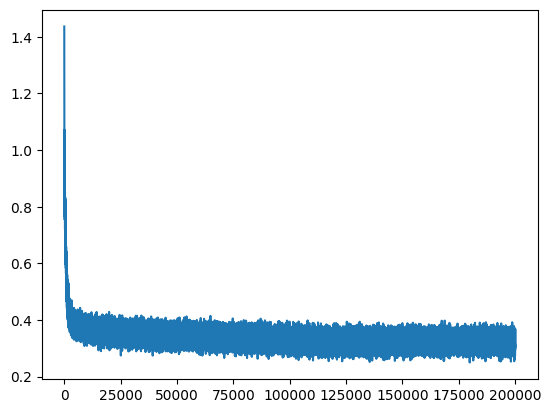

In [127]:
plt.plot(stepi, lossi)

In [128]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,40) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.115171194076538

In [129]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,40) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.152472496032715

In [103]:
C.shape

torch.Size([27, 10])

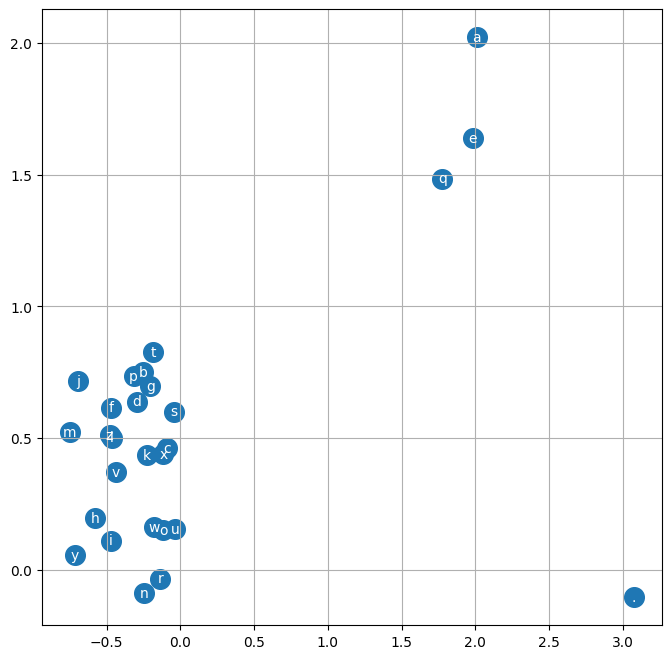

In [104]:
# When we embed the characters into two dimensions we can actually visualize the clustering of similar characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [105]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 4, 10])

In [109]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpah.
ambricki.
kimrli.
taty.
salayan.
jazonel.
deniya.
jarquic.
ramari.
chaiia.
kaleigh.
hamon.
cadesinn.
shoi.
wailandi.
wazero.
dearynn.
jaye.
pirsly.
edde.
iiabethaley.
fraulaan.
bedricsya.
samarioz.
ajloen.
iyla.
raen.
kalla.
lulo.
zoessi.
